# Trackster-level graph net with PU

Question: does including the neighborhood provide a benefit over the pairwise classification?

In [1]:
import numpy as np
import torch
import sys

import torch.nn as nn
from torch.optim import SGD
from torch_cluster import knn_graph
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

from reco.model import DynamicEdgeConvBlock

from reco.training import precision_recall_curve, roc_auc
from reco.loss import GraphClassificationLoss
from reco.datasetPU import TracksterGraph


ds_name = "CloseByTwoPion"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
def create_mask(data):
    # extract the focus feature
    data.mask = (1 - data.x[:,0]).type(torch.bool)
    return data

def knn_transform(data):
    # pos coordinates are on position 3:6
    data.edge_index = knn_graph(data.pos, k=4, loop=False)
    return data

def prepend_pos(data):
    # GravNet: add S to the front
    data.x = torch.hstack((data.pos, data.x))
    return data

transforms = T.Compose([prepend_pos])

In [4]:
ds = TracksterGraph(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=10,
    radius=100,
    bigT_e_th=75,
    # transform=transforms
    # pileup=True,
    # collection="CP"
)

# ds.processed_file_names
ds.data

Data(x=[51131, 39], y=[51131], pos=[51131, 3], e=[51131], shared_e=[51131], node_index=[51131])

In [5]:
len(ds.data.y)

51131

In [6]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train graphs: {len(train_set)}, Test graphs: {len(test_set)}, total: {ds_size}")

train_dl = DataLoader(train_set, batch_size=16, shuffle=True)
test_dl = DataLoader(test_set, batch_size=16, shuffle=True)

Train graphs: 1431, Test graphs: 159, total: 1590


In [7]:
class TracksterGraphNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, dropout=0.2, S=3):
        super(TracksterGraphNet, self).__init__()
        
        hdim1 = 64
        hdim2 = 64
        hdim3 = 64

        hdim_fc = 256

        self.edgeconv1 = DynamicEdgeConvBlock(input_dim, hdim1)
        self.edgeconv2 = DynamicEdgeConvBlock(hdim1, hdim2)
        self.edgeconv3 = DynamicEdgeConvBlock(hdim2, hdim3)
        
        # Edge features from node embeddings for classification        
        self.nodenetwork = nn.Sequential(
            nn.Linear(hdim3, hdim_fc),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hdim_fc, 3),
            nn.ReLU(),
            nn.Linear(3, output_dim),
            nn.Sigmoid()
        )

    def forward(self, X):
        H1 = self.edgeconv1(X)
        H2 = self.edgeconv2(H1)
        H3 = self.edgeconv3(H2)
        return self.nodenetwork(H3).squeeze(-1)

In [8]:
model = TracksterGraphNet(input_dim=ds.data.x.shape[1])
epochs = 10
model_path = f"models/TracksterGraphNet.GravNet.ns.{epochs}e-{ds_name}.{ds.RADIUS}.{ds.SCORE_THRESHOLD}.{ds.N_FILES}f.pt"

In [9]:
def train_graph_classification(model, device, optimizer, loss_func, train_dl):
    train_loss = []
    model.train()

    for data in train_dl:
        data = data.to(device)
        optimizer.zero_grad()

        seg_pred = model(data.x)
        loss = loss_func(data, seg_pred)
        loss.backward()

        optimizer.step()

        train_loss.append(loss.item())

    return np.mean(train_loss)

In [10]:
@torch.no_grad()
def test_graph_classification(model, device, loss_func, test_dl):
    test_loss = []
    model.eval()
    for data in test_dl:
        data = data.to(device)
        seg_pred = model(data.x)
        loss = loss_func(data, seg_pred)
        test_loss.append(loss.item())

    return np.mean(test_loss)

In [11]:
#%%script echo skipping

# alpha - percentage of negative edges
loss_func = GraphClassificationLoss()

model = model.to(device)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-5)

for epoch in range(epochs):

    train_loss = train_graph_classification(
        model,
        device,
        optimizer,
        loss_func,
        train_dl
    )
    
    scheduler.step()

    if epoch % 1 == 0:
        test_loss = test_graph_classification(model, device, loss_func, test_dl)
        print(
            f"Epoch {epoch}\t train loss: {train_loss:.3f}\t test loss: {test_loss:.3f}",
            file=sys.stderr
        )
        
torch.save(model.state_dict(), model_path)
print(model_path)

Epoch 0	 train loss: 5.733	 test loss: 5.533
Epoch 1	 train loss: 5.175	 test loss: 5.973
Epoch 2	 train loss: 4.128	 test loss: 5.657
Epoch 3	 train loss: 3.129	 test loss: 3.226
Epoch 4	 train loss: 2.075	 test loss: 1.647
Epoch 5	 train loss: 1.607	 test loss: 2.709
Epoch 6	 train loss: 1.525	 test loss: 2.520
Epoch 7	 train loss: 1.159	 test loss: 1.059
Epoch 8	 train loss: 0.918	 test loss: 0.918


models/TracksterGraphNet.GravNet.ns.10e-CloseByTwoPion.100.0.2.10f.pt


Epoch 9	 train loss: 0.850	 test loss: 0.819


In [12]:
%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

skipping


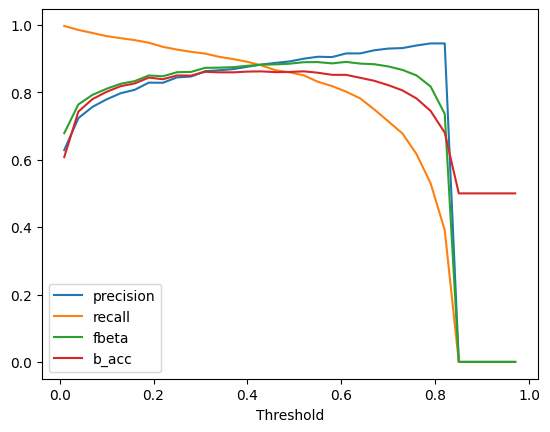

TP: 2492, TN: 2112, FP: 231, FN: 616
TH: 0.61 precision: 0.915 recall: 0.802 fbeta: 0.890 b_acc: 0.852


In [13]:
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=0.5, step=3, truth_threshold=0.5)

In [14]:
print(roc_auc(model, device, test_dl))

0.910275845721685


## Eval

## Results

Using alpha=balance seems to converge faster (100 epochs rather than 200)
- maybe just sticking to 0.25? (works just fine)

Hyperparams
- (64, 128, noskip), alpha=balance, roc_auc = 0.9733
- (64, 128, 256fc, noskip, 200e), alpha=1-balance, roc_auc = 0.9771
- (64, 128, 256fc, noskip, 200e), alpha=balance, roc_auc = 0.981
- (64, 128, 256fc, noskip, 100e), alpha=0.25, roc_auc = 0.9796

In [ ]:
import torch.onnx

onnx_filepath = f"onnx/TracksterGraphNet.mask.64.128.256.ns.{epochs}e-{ds_name}.{ds.RADIUS}.{ds.SCORE_THRESHOLD}.{ds.N_FILES}f.onnx"

torch.onnx.export(
    model,                          # model to be exported
    (ds[0].x),    # example input (add batch dimension)
    onnx_filepath,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['features'],      # the model's input names
    output_names=['output'],    # the model's output names
    dynamic_axes={              # variable length axes
        'features' : {0 : 'batch_size'},    
        'output' : {0 : 'batch_size'}
    }
)